In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# 计算lightGBM+CNNBiLSTM
df_lightGBM = pd.read_csv("./result/lightGBMpre-best.csv")
df_CNNBiLSTM = pd.read_csv("./result/CNN-BiLSTMpre-best.csv")

In [2]:
# 计算基模型的累计误差
def CumMSE(df_model:pd.DataFrame):
    """
    df_model第一列为true，第二列为pre
    """
    cum_mse = []
    for i in range(len(df_model)):
        cum_mse.append(mean_squared_error(df_model.iloc[:i+1,0],df_model.iloc[:i+1,1]))
    return cum_mse

cum_mse_lightGBM = CumMSE(df_lightGBM)
cum_mse_CNNBiLSTM = CumMSE(df_CNNBiLSTM)

# 计算组合权重
def CombineWeight(cum_mse1:list,cum_mse2:list):
    """
    :parameters:
    cum_mse1: 模型1累计误差 
    cum_mse2: 模型2累计误差
    
    :return: 
    模型1的组合权重
    """
    weightList = []
    for i in range(len(cum_mse1)):
        weightOfModel1 = cum_mse1[i]/sum([cum_mse1[i],cum_mse2[i]])
        weightList.append(weightOfModel1)
    return weightList

weight_lightGBM = CombineWeight(cum_mse_lightGBM,cum_mse_CNNBiLSTM)
    

In [4]:
# 计算lightGBM+CNNBiLSTM组合预测值
def CombineModel(df_Model1:pd.DataFrame,df_Model2:pd.DataFrame,combineWeightOfModel1:list):
    """
    :parameters:
    df_Model1: 模型1的结果
    df_Model2: 模型2的结果
    combineWeightOfModel1: 模型1的组合权重

    :return: 预测值
    """
    y_pre = []
    for idx,weight in enumerate(combineWeightOfModel1):
        prediction = df_Model1['y_pre'][idx] *weight + df_Model2['y_pre'][idx]*(1-weight)
        y_pre.append(prediction)
    return y_pre

y_pre = CombineModel(df_lightGBM,df_CNNBiLSTM,weight_lightGBM)
y = df_lightGBM.loc[:,'y_true']


In [5]:
# 计算lightGBM+CNNBiLSTM组合评价
r2Score = r2_score(y_true=y, y_pred=y_pre)
meanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
meanAbsoluteError = mean_absolute_error(y_true=y, y_pred=y_pre)
print("r2Score: ", r2Score)
print("meanSquaredError: ", meanSquaredError)
print('RMSE: ',np.sqrt(meanSquaredError))
print("meanAbsoluteError: ", meanAbsoluteError)


r2Score:  0.9874592500114563
meanSquaredError:  0.0006475745566911211
RMSE:  0.025447486254856707
meanAbsoluteError:  0.008720665109818292


In [6]:
df_evaluate = pd.read_csv("./result/组合模型结果.csv")
df_evaluate.columns

Index(['Model_name', 'r2-score', 'MSE', 'RMSE', 'MAE', 'Unnamed: 5'], dtype='object')

In [7]:
df_evaluate = df_evaluate[['Model_name', 'MSE', 'RMSE', 'MAE']].melt(id_vars='Model_name')
df_evaluate

,Model_name,variable,value
0,BiLSTM,MSE,0.001828
1,lightGBM,MSE,0.000984
2,CNN-BiLSTM,MSE,0.001383
3,lightGBM+BiLSTM,MSE,0.001281
4,lightGBM+CNN-BiLSTM,MSE,0.000648
5,BiLSTM,RMSE,0.042752
6,lightGBM,RMSE,0.031375
7,CNN-BiLSTM,RMSE,0.037185
8,lightGBM+BiLSTM,RMSE,0.035787
9,lightGBM+CNN-BiLSTM,RMSE,0.025447


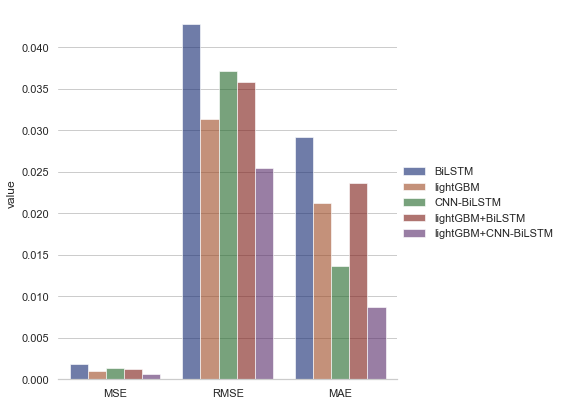

In [8]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_evaluate, kind="bar",
    x="variable"	, y="value", hue="Model_name",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "value")
g.legend.set_title("")